In [ ]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

In [ ]:
from importlib import reload
import numpy as np
import torchvision
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.auto import tqdm, trange
import mmcv
import data
import bbox
from utils import imshow
import meva
from meva.lib.meva_model import MEVA
from meva.utils import kp_utils
from meva.utils import image_utils
from meva.utils.video_config import update_cfg
from torch.utils.data import DataLoader

In [3]:
vid_folder = 'videos'
anno_folder = '/media/tormod/Den Lille/Thesis/annotations'
feature_folder = '/media/tormod/Den Lille/Thesis/hmr_features'

c = data.ClimbingDataset(vid_folder, anno_folder, 'all', feat_folder=feature_folder)

Reading features for ... IMG_2139 IMG_2140 IMG_2141 IMG_2142 

In [4]:
sample = c.get(0)
labels = sample['climb_labels']
imgs = sample['raw_imgs']
feats = sample['features']

In [7]:
labels.shape

(90, 19, 3)

In [7]:
bboxes = image_utils.get_bbox_from_kp2d(labels).T

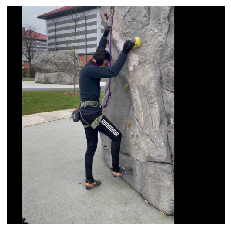

In [8]:
img = imgs[0]
imshow(bbox.bbox_crop(img, bbox.cxcywh2xyxy(bboxes)[0]))


In [5]:
pretrained_file = f"results/meva/train_meva_2/model_best.pth.tar"
config_file = f"meva/cfg/train_meva_2.yml"
cfg = update_cfg(config_file)

In [14]:
model = MEVA(
    n_layers=cfg.MODEL.TGRU.NUM_LAYERS,
    batch_size=cfg.TRAIN.BATCH_SIZE,
    seqlen=cfg.DATASET.SEQLEN,
    hidden_size=cfg.MODEL.TGRU.HIDDEN_SIZE,
    add_linear=cfg.MODEL.TGRU.ADD_LINEAR,
    bidirectional=cfg.MODEL.TGRU.BIDIRECTIONAL,
    use_residual=cfg.MODEL.TGRU.RESIDUAL,
    cfg=cfg.VAE_CFG,
).to('cuda')
ckpt = torch.load(pretrained_file)
# print(f'Performance of pretrained model on 3DPW: {ckpt["performance"]}')
ckpt = ckpt['gen_state_dict']
model.load_state_dict(ckpt)
model.eval()

In [6]:
dataloader = DataLoader(c, batch_size=cfg.TRAIN.BATCH_SIZE, num_workers=16, shuffle = False)

In [7]:
c.len

181

In [8]:
for seqs in dataloader.batch_sampler:
    print(seqs)
    feats = np.stack([c[seq] for seq in seqs])
    print(feats.shape)
    break

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
(32, 90, 2048)
